# Train a Model via API

This notebook demonstrates how to train, test and infer the EfficientAD model via Anomalib API. Compared to the CLI entrypoints such as \`tools/\<train, test, inference>.py, the API offers more flexibility such as modifying the existing model or designing custom approaches.

## Setting up the Dataset Directory

This cell is to ensure we change the directory to have access to the datasets.


In [1]:
# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = "/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified"

## Imports


In [2]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import torch
from pathlib import Path

from anomalib.data import PredictDataset, Folder
from anomalib.engine import Engine
from anomalib.models import Dfkde
from anomalib import TaskType
from anomalib.loggers import AnomalibTensorBoardLogger
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.utils.normalization import NormalizationMethod
import os, pprint, yaml, warnings, math, glob, cv2, random, logging
%matplotlib inline
torch.cuda.empty_cache()

## Data Module

To train the model end-to-end, we do need to have a dataset. In our [previous notebooks](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules), we demonstrate how to initialize benchmark- and custom datasets. In this tutorial, we will use MVTec AD DataModule. We assume that `datasets` directory is created in the `anomalib` root directory and `MVTec` dataset is located in `datasets` directory.

Before creating the dataset, let's define the task type that we will be working on. In this notebook, we will be working on a segmentation task. Therefore the `task` variable would be:


In [3]:
task = TaskType.CLASSIFICATION

In [4]:
datamodule = Folder(
    #root="/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset",
    name="",
    root=dataset_root,
    normal_dir="train/FC",
    abnormal_dir="train/NG",
    #normal_test_dir="val/FC",
    normal_split_ratio=0.0,
    image_size=(256, 256),
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=4,
    task=task,
)

datamodule.setup()
datamodule.prepare_data()

i, data = next(enumerate(datamodule.test_dataloader()))
print(data["image"].shape)

torch.Size([32, 3, 256, 256])


In [5]:
len(datamodule.train_dataloader())

8

## DFKDE Model

Now that we have created the Folder datamodule, we could create the DFKDE model. We could start with printing its docstring.


In [6]:
#Dfkde??

In [7]:
model = Dfkde(
    backbone="resnet18",
    layers=['layer3'],
    pre_trained=True,
    max_training_points=3000
)

## Training

Now that we set up the datamodule, model, optimizer and the callbacks, we could now train the model.

The final component to train the model is `Engine` object, which handles train/test/predict pipeline. Let's create the engine object to train the model.


In [8]:
#logger = AnomalibTensorBoardLogger("tb_logs", name="DFKDE_Resnet18_logs_WR50layer2")

engine = Engine(
    normalization=NormalizationMethod.MIN_MAX,
    threshold="F1AdaptiveThreshold",
    image_metrics = ["F1Score", "AUROC", "Precision", "Recall"],
    accelerator="gpu",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices="auto",
    task=TaskType.CLASSIFICATION,
    #logger=logger
)

`Trainer` object has number of options that suit all specific needs. For more details, refer to [Lightning Documentation](https://pytorch-lightning.readthedocs.io/en/stable/common/engine.html) to see how it could be tweaked to your needs.

Let's train the model now.


In [9]:
import os

# Your original path
original_path = "~/cloudfiles/code/Users/rohit.potdukhe/Dataset/v1.0.0/train"

# Expand the tilde to the full home directory path
expanded_path = os.path.expanduser(original_path)

print(expanded_path)  # This should print the correct path

/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/v1.0.0/train


In [9]:
engine.fit(datamodule=datamodule, model=model)

Epoch 0/0  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 0:00:02 • 0:00:00 7.82it/s  

`Trainer.fit` stopped: `max_epochs=1` reached.


## Test

In [10]:
"""
Package_modified
model = Dfkde(
    backbone="resnet18",
    layers=['layer3'],
    pre_trained=True,
    max_training_points=3000
)"""

engine.test(datamodule=datamodule, model=model)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 0:00:42 • 0:00:00 0.12it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7589843273162842     │
│       image_F1Score       │    0.8888888955116272     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8888888955116272, 'image_AUROC': 0.7589843273162842}]

In [82]:
#Testing with model = Dfkde(
#    backbone="resnet18",
#    layers=['layer3'],
#    pre_trained=True,
#)

engine.test(datamodule=datamodule, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7427549958229065     │
│       image_F1Score       │    0.8336933255195618     │
└───────────────────────────┴───────────────────────────┘

[{'image_F1Score': 0.8336933255195618, 'image_AUROC': 0.7427549958229065}]

In [11]:
from anomalib.deploy import ExportType

export_root = Path.cwd() / 'weights' / 'DFKDE_package'

export_root.mkdir(parents=True, exist_ok=True)

# Exporting model to OpenVINO
openvino_model_path = engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    export_root=str(export_root),
)

from anomalib.deploy import ExportType

export_root = Path.cwd() / 'Dfm_dn169_weights_ipig'

export_root.mkdir(parents=True, exist_ok=True)

# Exporting model to OpenVINO
openvino_model_path = engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    export_root=str(export_root),
)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/rohit-unite-23-may/code/Users/rohit.potdukhe/unite/anomalib/src/anomalib/models/image/dfkde/torch_model.py:67: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  batch_size = len(layer_outputs[layer])


## Inference

Since we have a trained model, we could infer the model on an individual image or folder of images. Anomalib has an `PredictDataset` to let you create an inference dataset. So let's try it.


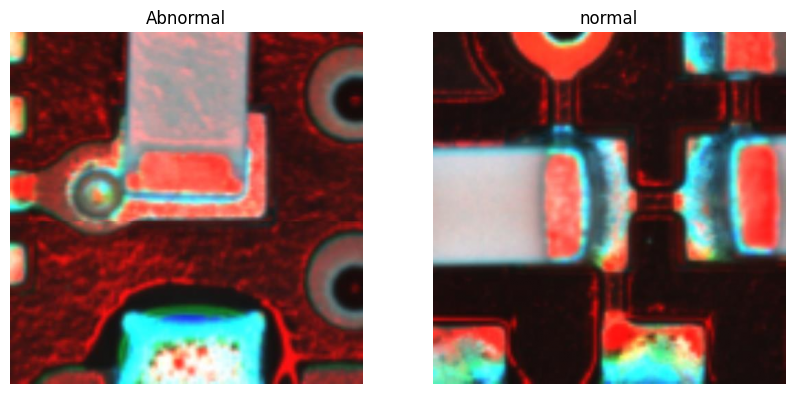

In [15]:
%matplotlib inline

image_normal = read_image(path="/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC/Package102_BF1911027564_102_2_7_7_Multi.jpg")
image_abnormal = read_image(path="/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG/Package102_BF2001009461_602_8_6_6_Multi.jpg")


# Plot the images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_abnormal)
plt.axis('off')  
plt.title("Abnormal")

plt.subplot(1, 2, 2)
plt.imshow(image_normal)
plt.axis('off')  
plt.title("normal")

plt.show()

## Visualization


In [16]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [17]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

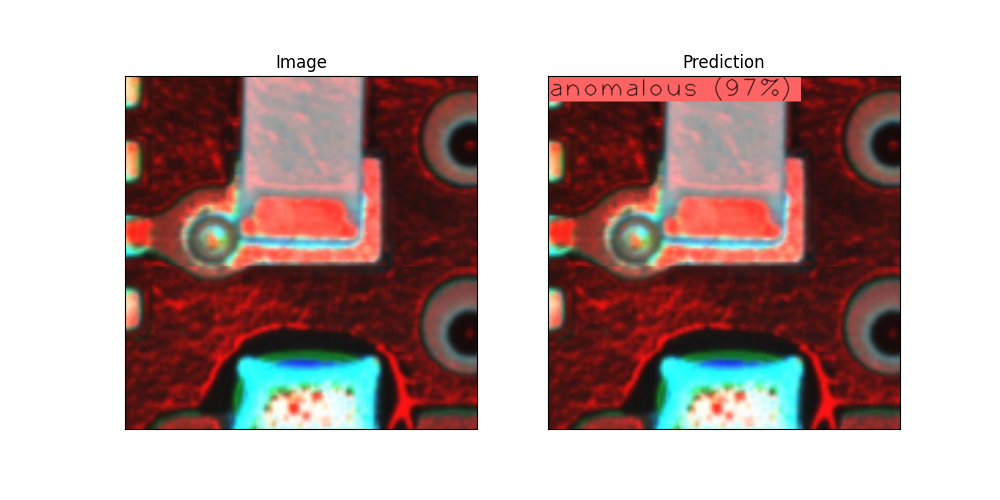

In [18]:
from anomalib.utils.visualization.image import ImageVisualizer, VisualizationMode
from PIL import Image

predictions = inferencer.predict(image=image_abnormal)
visualizer = ImageVisualizer(mode=VisualizationMode.FULL, task=task)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

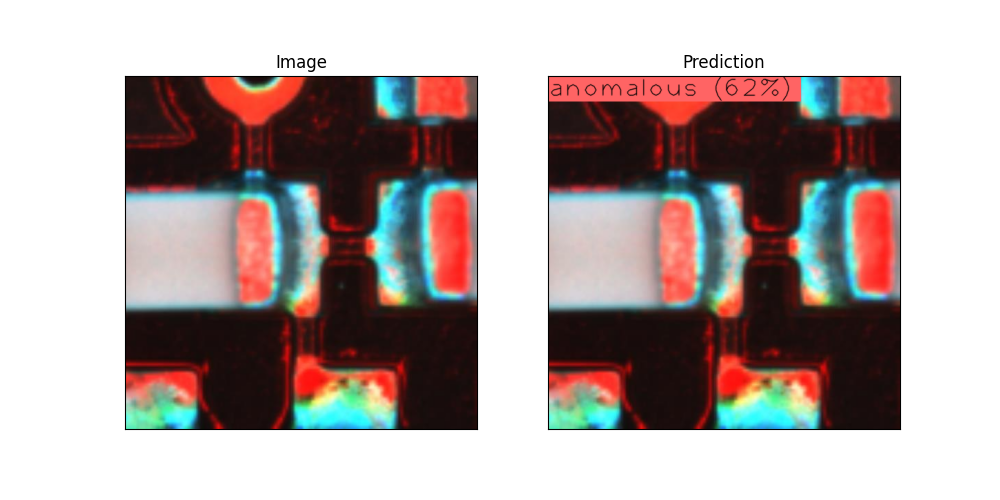

In [19]:
predictions = inferencer.predict(image=image_normal)
visualizer = ImageVisualizer(mode=VisualizationMode.FULL, task=task)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

## prediction  on all images

In [16]:
def inference(dataset_path, label):
    predictions = []

    image_paths = list(dataset_path.glob("**/*.jpg"))

    for image_path in image_paths:
        image = read_image(image_path)

        prediction = inferencer.predict(image=image)
        predictions.append((image_path, prediction, label))
    
    return predictions


In [17]:
def process_all_predictions(normal_predictions, abnormal_predictions):
    all_predictions = []
    all_labels = []
    misclassified_files = []

    # Process normal predictions
    for file_path, image_result, _ in normal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(0)  # 0 for normal
        if pred_label != 0:
            misclassified_files.append((file_path, 'Normal', 'Predicted as Abnormal'))

    # Process abnormal predictions
    for file_path, image_result, _ in abnormal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(1)  # 1 for abnormal
        if pred_label != 1:
            misclassified_files.append((file_path, 'Abnormal', 'Predicted as Normal'))
        
    return all_predictions, all_labels, misclassified_files

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred)

    # Create a figure and a set of subplots
    plt.figure(figsize=(8, 6))
    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

## Inference with

model = Dfkde(
    backbone="resnet18",
    layers=['layer3'],
    pre_trained=True,
    max_training_points=3000
)

In [58]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Dataset/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [59]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions=, abnormal_predictions)

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7071428571428572
Precision: 0.6355140186915887
Recall: 0.9714285714285714
F1 Score: 0.768361581920904


No such comm: d972b7c1fa2347e3aab51e670c7b1dae


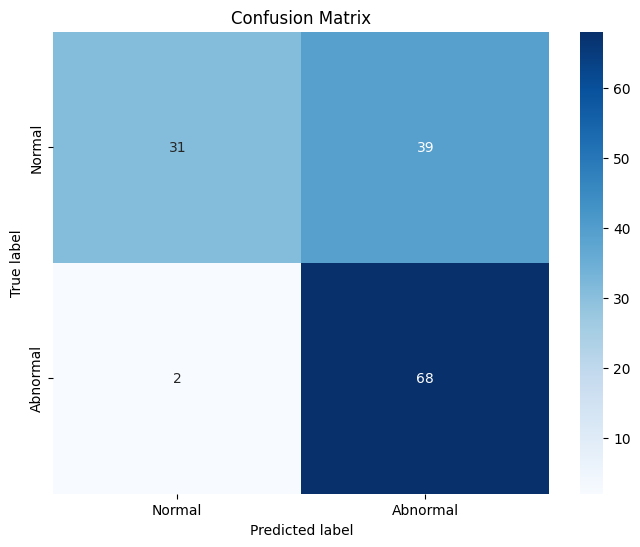

In [61]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)


## Inference with package_modified

model = Dfkde(
    backbone="resnet18",
    layers=['layer3'],
    pre_trained=True,
    max_training_points=3000
)

In [20]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/pred_test/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/pred_test/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

NameError: name 'metadata_path' is not defined

In [82]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6785714285714286
Precision: 0.6344086021505376
Recall: 0.8428571428571429
F1 Score: 0.7239263803680982


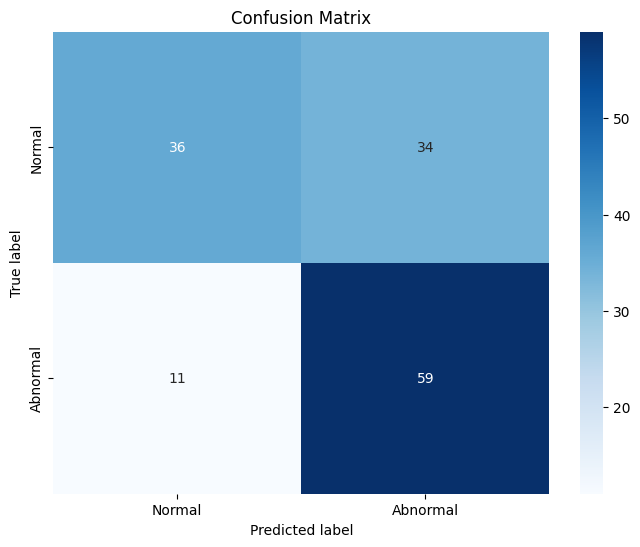

In [84]:
%matplotlib inline

class_names = ['Normal', 'Abnormal']
plot_confusion_matrix(all_labels, all_predictions, class_names)
